In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

In [3]:
import seerhelp
otherfiles = seerhelp.get_otherfiles()
otherfiles

dfother0 = seerhelp.make_clean_dataframe(otherfiles[0])
dfother1 = seerhelp.make_clean_dataframe(otherfiles[1])
dfother2 = seerhelp.make_clean_dataframe(otherfiles[2])
dfother3 = seerhelp.make_clean_dataframe(otherfiles[3])

dfother = pd.concat([dfother0, dfother1, dfother2,
                     dfother3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfother.shape)

del dfother0
del dfother1
del dfother2
del dfother3

(1581838, 141)


This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes for those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify the following Head and Neck cancer patients using the following primary site codes:

* Nasopharynx: (C110, C111, C12, C13, C118, C19)
* Oropharynx: (C091, C098, C099, C100, C101, C102, C103, C104, C108, C109)
* Salivary gland: (C079-C081, C088-C089)
* Pituitary gland: (C751)

Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation; and the control group, defined as the patients who did not receive any form of radiation. Operationally, these groups are defined by looking at the column RADIATN, which has values:

| Code | Description |
|:--------:|:--------------:|
|0	|None; diagnosed at autopsy|
|1|	Beam radiation|
|2|	Radioacative implants|
|3|	Radioisotopes|
|4	|Combination of 1 with 2 or 3|
|5	|Radiation, NOS - method or source not specified|
|6	|Other radiation (1973-1987 cases only)|
|7	|Patient or patient's guardian refused radiation therapy|
|8|	Radiation recommened, unknown if administered|
|9	|Unknown if radiation administered|

So that a value of 0 defines the control group, and the values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [6]:
nasopharynxfilter = dfother.PRIMSITE.str.contains('nasopharynx',case=False,na=False)
print(nasopharynxfilter.sum())

11963


In [7]:
oropharynxfilter = dfother.PRIMSITE.str.contains('oropharynx',case=False,na=False)
print(oropharynxfilter.sum())

5168


In [8]:
salivaryfilter = dfother.PRIMSITE.str.contains('salivary',case=False,na=False)
print(salivaryfilter.sum())

1027


In [9]:
pituitaryfilter = dfother.PRIMSITE.str.contains('pituitary',case=False,na=False)
print(pituitaryfilter.sum())

32340


In [12]:
headandneckfilter = nasopharynxfilter | oropharynxfilter | salivaryfilter | pituitaryfilter
dfotherorig = dfother[headandneckfilter].copy()
dfotherorig.PRIMSITE.value_counts()

Pituitary gland                                32340
Nasopharynx, NOS                                8670
Oropharynx, NOS                                 3215
Posterior wall of nasopharynx                   1230
Lateral wall of nasopharynx                     1049
Major salivary gland, NOS                       1002
Overlapping lesions of oropharynx                764
Posterior wall of oropharynx                     659
Overlapping lesion of nasopharynx                604
Lateral wall of oropharynx                       530
Superior wall of nasopharynx                     212
Anterior wall of nasopharynx                     198
Overlapping lesion of major salivary glands       25
Name: PRIMSITE, dtype: int64

In [13]:
mask = (dfotherorig['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfotherorig['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfotherorig['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfotherorig['CSTUMSIZ'] != "Not applicable") & \
(dfotherorig['AGE_DX'] != "Unknown age") & \
(dfotherorig['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfotherorig['YEAR_DX'] >= 2004) & \
(dfotherorig['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfotherorig['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfotherorig['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfotherorig['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfotherorig['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfotherorig['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfotherorig['CSTUMSIZ'] != "Not applicable") & \
(dfotherorig['YR_BRTH'] != 'Unknown year of birth') & \
(dfotherorig['CSTUMSIZ'] != 'Not applicable') & \
(dfotherorig['CSTUMSIZ'] != 996) & \
(dfotherorig['CSTUMSIZ'] != 997) & \
(dfotherorig['CSTUMSIZ'] != 998) & \
(dfotherorig['REC_NO'] == 1) 

dfheadandneck = dfotherorig[mask]

In [14]:
dfheadandneck.RADIATN.value_counts()

None; diagnosed at autopsy                                                  18953
Beam radiation                                                               3980
Radiation recommended, unknown if administered                                113
Unknown if radiation administered                                              80
Patient or patient's guardian refused radiation therapy                        76
Radiation, NOS - method or source not provided                                 49
Combination of beam radiation with radioactive implants or radioisotopes       12
Radioactive implants                                                            3
Radioisotopes                                                                   1
Name: RADIATN, dtype: int64

In [15]:
dfheadandneck.SEX.value_counts()

Female    12030
Male      11237
Name: SEX, dtype: int64

In [16]:
non_rad = dfheadandneck.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfheadandneck.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfheadandneck.RADIATN.str.contains('Unknown',case=False,na=False)

In [17]:
dfheadandneckcontrol = dfheadandneck[non_rad | refused_rad].copy()
dfheadandnecktreatment = dfheadandneck[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [18]:
print(dfheadandneckcontrol.shape, dfheadandnecktreatment.shape)


(19029, 141) (4045, 141)


## <font color='steelblue'>So we are going to match patients in the treatment group with their nearest neighbors in the control group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [19]:
dfheadandneckcontrol.set_index('PUBCSNUM', inplace=True)
dfheadandnecktreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfheadandneckcontrol.index
treatmentindices = dfheadandnecktreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfheadandneckcontrol, dfheadandnecktreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves

In [20]:
resgoodcontrol = pd.concat([pd.get_dummies(dfheadandneckcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfheadandnecktreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfheadandneckcontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfheadandneckcontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfheadandneckcontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfheadandneckcontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfheadandneckcontrol['lat']
resgoodcontrol['lng'] = dfheadandneckcontrol['lng']
resgoodcontrol['srv_time_mon'] = dfheadandneckcontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfheadandnecktreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfheadandnecktreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfheadandnecktreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfheadandnecktreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfheadandnecktreatment['lat']
resgoodtreatment['lng'] = dfheadandnecktreatment['lng']
resgoodtreatment['srv_time_mon'] = dfheadandnecktreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

## <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and treatment groups together in pairs.

In [21]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All head and neck');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 4045 observations, 2837 censored>

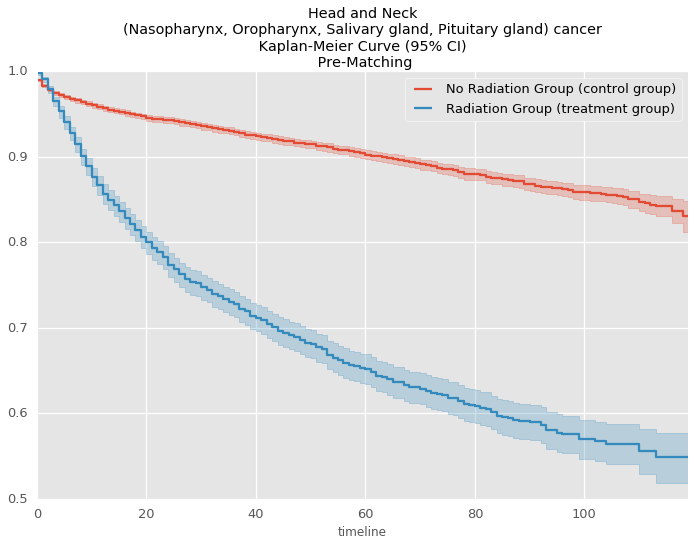

In [22]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Head and Neck\n(Nasopharynx, Oropharynx, Salivary gland, Pituitary gland) cancer\n Kaplan-Meier Curve (95% CI) \n Pre-Matching");